In [47]:
import os
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from time import sleep
from pymed import PubMed
import random
import wikipediaapi

In [48]:
# I save the corpus in memory as a list of tuples (document, category) because the NaiveBayesClassifier accepts the input in this shape
corpus = []
for file in os.listdir('pages'):
    with open('pages/' + file, 'r') as f:
        corpus.append((f.read(), file.split('[')[1].split(']')[0]))

# I print the number of documents in the corpus and the number of medical and non-medical documents
print(f'The corpus contains {len(corpus)} documents, {len([_ for _, cat in corpus if cat == "medical"])} medical and {len([_ for _, cat in corpus if cat == "non-medical"])} non-medical')

# I shuffle the corpus to avoid any bias, i use the seed to get the same shuffle every time
random.Random(1).shuffle(corpus)

# I use NLTK to get the stopwords and the SnowballStemmer for the english language to remove unneccessary words and get the roots of the remaining ones
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

# I preprocess the documents by tokenizing them using NLTK word_tokenize, removing the stopwords and stemming the words
preprocessed_documents = []
for document, category in corpus:
    words = word_tokenize(document.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    preprocessed_documents.append((words, category))

# I get the 4000 most common words in the corpus and I save them in a list to use them as features later on
all_words = []
for words, _ in preprocessed_documents:
    all_words.extend(words)
word_freq = FreqDist(all_words)
most_common_words = [word for word, _ in word_freq.most_common(4000)]

# I define a function to extract the features from the documents using the 4000 most common words: if a word is present in the document, the feature is True, otherwise it is False (Bag of Words)
def document_features(document):
    document_words = set(document)
    features = {}
    for word in most_common_words:
        features[word] = (word in document_words)
    return features

The corpus contains 1500 documents, 800 medical and 700 non-medical


              precision    recall  f1-score   support

     medical       0.95      0.92      0.93       150
 non-medical       0.92      0.95      0.93       150

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



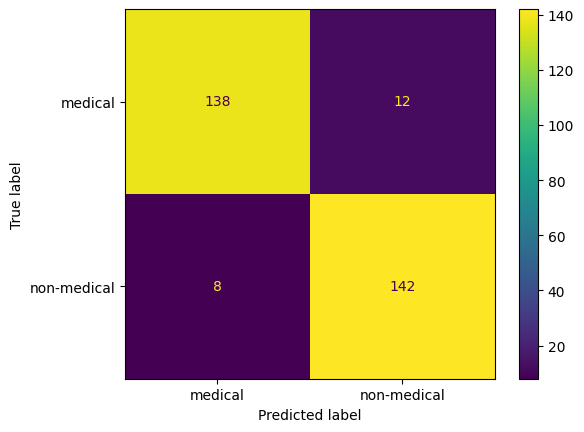

In [49]:
# I create the featuresets for the documents and I split them into train and test sets, with a 80/20 ratio
featuresets = [(document_features(doc), category) for doc, category in preprocessed_documents]
train_features = featuresets[:int(len(featuresets)*0.8)]
test_features = featuresets[int(len(featuresets)*0.8):]

# I train the Naive Bayes classifier and I test it on the test set
classifier = NaiveBayesClassifier.train(train_features)
y_pred = classifier.classify_many([doc for doc, _ in test_features])
y_true = [cat for _, cat in test_features]

# I print the classification report and the confusion matrix
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=['medical', 'non-medical'])
plt.show()

In [50]:
# I test the classifier on a new Wikipedia page
wikipedia = wikipediaapi.Wikipedia('test (my@email.address)''en')
page_title = 'French Revolution'

In [51]:
input_text = wikipedia.page(page_title).text
input_words = word_tokenize(input_text.lower())
input_words = [word for word in input_words if word.isalpha() and word not in stop_words]
input_words = [stemmer.stem(word) for word in input_words]
input_features = document_features(input_words)
predicted_category = classifier.classify(input_features)
print(f'The page "{page_title}" is classified as {predicted_category}')

The page "French Revolution" is classified as non-medical


In [52]:
# I test the classifier on PubMed articles
pubmed = PubMed(tool="test", email="my@email.address")
query = 'Coronavirus'
results = pubmed.query(query, max_results=500)

In [53]:
predictions = []
for article in results:
    article_title = article.title
    input_text = article.abstract
    if input_text is None:
        continue
    input_words = word_tokenize(input_text.lower())
    input_words = [word for word in input_words if word.isalpha() and word not in stop_words]
    input_words = [stemmer.stem(word) for word in input_words]
    input_features = document_features(input_words)
    predicted_category = classifier.classify(input_features)
    predictions.append(predicted_category)
print(f'{predictions.count("medical")} PubMed articles out of {len(predictions)} about {query} where classified as medical')

470 PubMed articles out of 489 about Coronavirus where classified as medical


To find and download the pages from wikipedia I used the package *Wikipedia-API* which makes it easier to call the APIs of Wikipedia to download pages, find the content, the title etc.

**add_pages**:
it recursively adds pages, not already in the list of *titles* and from the *categorymembers* of the chosen category, to the list of pages until it reaches the max number of pages, from time to time I also put a lower and a higher threshold for the amount of characters in the pages: most of the pages have atleast 10000 characters (~1500/2000 words) and a small amount more than 50000 or less than 7500. 

For medical pages I looked in the categories under the section *'Health and fitness'* at this url: https://en.wikipedia.org/wiki/Wikipedia:Contents/Categories, in particular the categories of the subsections: *'Medicine'*, *'Psychology'*, *'Health science'*, *'Dentistry'*, for example: *'Medicine'*, *'Oncology'*, *'Psychiatry'*, *'Epidemiology'*, *'Surgery'*, *'Optometry'*, *'Pharmacy'*, *'Urology'*, *'Mental health'*, *'Cardiology'* etc.

For non-medical pages I mainly looked in the categories: *'Sports'*, *'Politics'*, *'Games'*, *'Film'*, *'Artificial intelligence'*, *'Museums'*, *'Crime'*, *'Equations'*, *'Cars'*, *'Cycling'*, *'Literature'*.


**download_pages**:
it downloads the pages in the *pages_list* in the folder 'pages'. For medical pages it adds the suffix '[medical]' to the file name, for non-medical pages it adds the suffix '[non-medical]'.

In [54]:
# Cell used to find the pages and download them
wikipedia = wikipediaapi.Wikipedia('test (my@email.address)''en')
def add_pages(categorymembers, pages, max_pages, level=0, max_level=1, titles=[]):
    for c in categorymembers.values():
        sleep(0.1)
        if len(pages) == max_pages:
            return pages
        elif c.ns == wikipediaapi.Namespace.CATEGORY and level < max_level:
            add_pages(c.categorymembers, pages, max_pages, level=level + 1, max_level=max_level, titles=titles)
        elif c.ns == wikipediaapi.Namespace.MAIN and len(pages) < max_pages:
            if c.title not in titles:
                pages.append(wikipedia.page(c.title))
                if len(pages) % 10 == 0:
                    print(f'Found page {c.title}, number of pages found: {len(pages)}')
    return pages

def download_pages(pages_list, medical=False):
    for pages in pages_list:
        try:
            if medical:
                with open('pages/' + pages.title + '[medical].txt', 'w') as f:
                    f.write(pages.text)
            else:
                with open('pages/' + pages.title + '[non-medical].txt', 'w') as f:
                    f.write(pages.text)
        except:
            pass